In [1]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from analysis import *
from plots import *
from process import filt_condition

%matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [2]:
result_dir = 'results'


output_dir = config['output_dir']
output_dir = './PCA_output_download/'
# output_dir = './v1_output/'

In [15]:
genotypes = ['Pvalb', 'Sst']
n_genotypes = len(genotypes)

optotag_filt_df = {}
for genotype in genotypes:
    df = pd.read_csv(os.path.join('results', f'{genotype:s}_optotag_units.csv'), index_col='unit_id')
    df = df[df['positive']]
    optotag_filt_df[genotype] = df

## Select sessions for analysis

In [4]:
## Select sessions for analysis
# Read session selection
session_selection_file = 'session_selection'
# session_selection_file = 'session_selection_all'

session_selection = pd.read_csv(os.path.join(result_dir, session_selection_file + '.csv'), index_col='session_id')

In [5]:
session_ids = []
for df in optotag_filt_df.values():
    session_ids.extend(df['session_id'].unique())

session_selection = session_selection.loc[session_ids]
session_selection['genotype'] = [s.split('/', 1)[0].split('-', 1)[0] for s in session_selection['full_genotype']]

In [6]:
session_selection

,session_type,full_genotype,ecephys_structure_acronyms,psd good,genotype
session_id,,,,,
721123822,brain_observatory_1.1,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Pvalb
840012044,functional_connectivity,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Pvalb
756029989,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Sst
794812542,functional_connectivity,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Sst
831882777,functional_connectivity,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Sst
839068429,functional_connectivity,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,Sst


#### Get probe directory

In [7]:
session_ids = []
probe_dirs = []
for session_id, row in session_selection.iterrows():
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    if not os.path.isdir(session_dir):
        print(f"Missing session directory for session {session_id:d}")
        continue
    ecephys_structure_acronym = row['ecephys_structure_acronyms']
    info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
    if os.path.isfile(info_file):
        with open(info_file) as f:
            probe_id = json.load(f)['probe_id']
            probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
    else:
        for probe_dir in os.listdir(session_dir):
            if probe_dir.startswith('probe_'):
                probe_dir = os.path.join(session_dir, probe_dir)
                break
        else:
            probe_dir = ''
    if not os.path.isdir(probe_dir):
        print(f"Missing probe directory for session {session_id:d}")
        raise FileNotFoundError(probe_dir)
    session_ids.append(session_id)
    probe_dirs.append(probe_dir)

session_selection = session_selection.loc[session_ids]
session_selection['probe_dir'] = probe_dirs

Missing session directory for session 840012044
Missing session directory for session 756029989
Missing session directory for session 794812542
Missing session directory for session 831882777
Missing session directory for session 839068429


## Analyze firing rate

In [8]:
colors = {'beta': 'b', 'gamma': 'r'}
waves = list(colors)
n_waves = len(waves)
genotype_clrs = {'Pvalb': 'tab:red', 'Sst': 'tab:blue'}

# Set the combination of stimuli
stimulus_names = {
    'brain_observatory_1.1': ['drifting_gratings', 'natural_movie_one', 'natural_movie_three'],
    'functional_connectivity': ['drifting_gratings_75_repeats', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']
}

movie_stims = ['natural_movie_one', 'natural_movie_three', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']

# Select drifting gratings conditiona
condition_filter = {
    'brain_observatory_1.1': dict(
        cond_name = 'temporal_frequency',
        cond_filt = lambda x: x < 5
    ),
    'functional_connectivity': dict(
        cond_name = 'contrast',
        cond_filt = lambda x: x > 0.5
    )
}

In [9]:
from collections import defaultdict

units_frs = defaultdict(dict)
condition_ids = {}
cond_presentation_ids = {}
for session_id, row in session_selection.iterrows():
    probe_dir = row['probe_dir']
    ecephys_structure_acronym = row['ecephys_structure_acronyms']
    session_type = row['session_type']
    df = optotag_filt_df[row['genotype']]
    sel_units = df[df['session_id'] == session_id].index
    # map from condition id to presentation id in drifting gratings
    cond_map_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_dg_condition_map.nc')
    cond_map = xr.load_dataarray(cond_map_file)
    condition_id, cond_presentation_id = filt_condition(cond_map, **condition_filter[session_type])
    condition_ids[session_id] = condition_id  # filtered conditions
    cond_presentation_ids[session_id] = cond_presentation_id
    all_cond_presentation_id = np.concatenate(list(cond_presentation_id.values()))
    # load spike data
    for stim in stimulus_names[session_type]:
        filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stim:s}')
        spk_file = filepath_prefix + '_unit_spike_counts.nc'
        spk_counts = xr.load_dataset(spk_file)
        spk_counts = spk_counts.sel(unit_id=[i for i in spk_counts.unit_id.values if i in sel_units])
        # spike counts to firing rate
        spk_counts = spk_counts.rename(spike_counts='spike_rate')
        spk_counts = spk_counts.assign(spike_rate=spk_counts.spike_rate / spk_counts.bin_width)
        # average over trials
        if stim in movie_stims:
            units_frs[stim][session_id] = spk_counts.assign(spike_rate=spk_counts.spike_rate.mean(dim='stimulus_presentation_id'))
        else:
            fr = spk_counts.spike_rate.sel(stimulus_presentation_id=all_cond_presentation_id).mean(dim='stimulus_presentation_id')
            units_frs[stim][session_id] = spk_counts.assign(spike_rate=fr)

# concatenate across sessions
for stim in units_frs:
    frs = list(units_frs[stim].values())
    windows = np.array([fr.time_relative_to_stimulus_onset[[0, -1]] for fr in frs])
    n_time = max(fr.time_relative_to_stimulus_onset.size for fr in frs)
    interp_time = np.linspace(windows[:, 0].min(), windows[:, 1].max(), n_time)
    frs_interp = [fr.interp(time_relative_to_stimulus_onset=interp_time) for fr in frs]
    units_frs[stim] = xr.concat(frs_interp, dim='unit_id')

# separate genotypes
unit_ids = set()
for frs in units_frs.values():
    unit_ids.update(frs.unit_id.values)
sel_units = {}
for genotype, df in optotag_filt_df.items():
    sel_units[genotype] = df[df.index.isin(unit_ids)].index.values

### Plot average firing rate

In [16]:
genotypes = ['Pvalb']
n_genotypes = 1

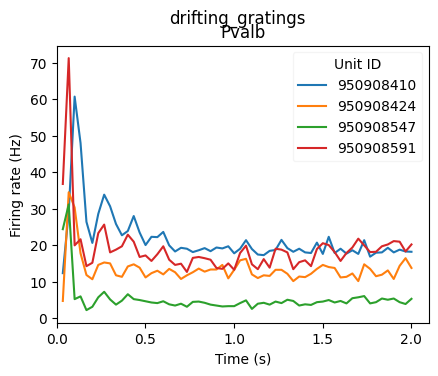

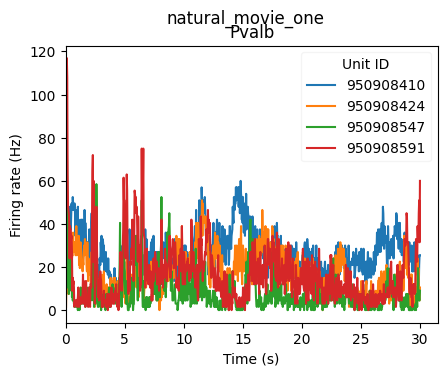

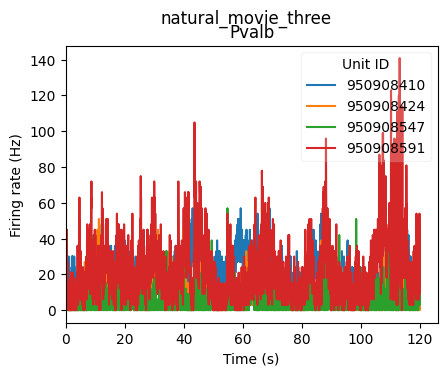

In [23]:
figsize = (4.8, 3.6)

for stim, frs in units_frs.items():
    fig, axs = plt.subplots(1, n_genotypes, figsize=(figsize[0] * n_genotypes, figsize[1]), squeeze=False)
    t = frs.time_relative_to_stimulus_onset
    for i, genotype in enumerate(genotypes):
        ax = axs[0, i]
        unit_ids = sel_units[genotype]
        fr = frs.spike_rate.sel(unit_id=unit_ids)
        ax.plot(t, fr.values, label=unit_ids)
        ax.set_xlim(left=0)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Firing rate (Hz)')
        ax.set_title(genotype)
        leg = ax.legend(loc='upper right', framealpha=0.2)
        leg.set_title('Unit ID')
    fig.suptitle(stim)
    plt.show()

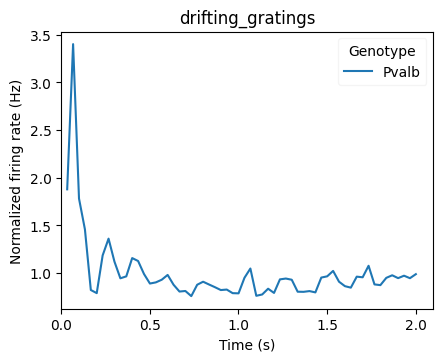

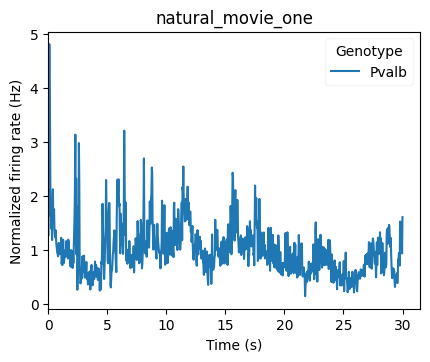

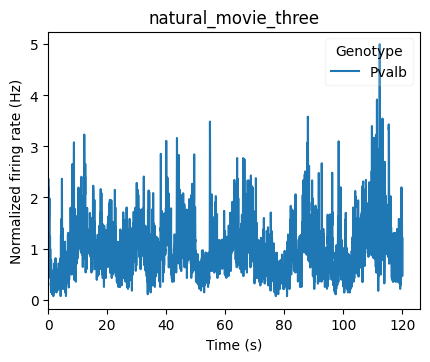

In [24]:
figsize = (4.8, 3.6)

for stim, frs in units_frs.items():
    fig, ax = plt.subplots(1, 1, figsize=(figsize[0], figsize[1]))
    t = frs.time_relative_to_stimulus_onset
    frs = frs.spike_rate / frs.spike_rate.mean(dim='time_relative_to_stimulus_onset')  # normalize by mean
    for genotype in genotypes:
        fr = frs.sel(unit_id=sel_units[genotype]).mean(dim='unit_id')
        ax.plot(t, fr.values, label=genotype)
    ax.set_xlim(left=0)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized firing rate (Hz)')
    ax.set_title(stim)
    leg = ax.legend(loc='upper right', framealpha=0.2)
    leg.set_title('Genotype')
    plt.show()